In [1]:
#load libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

the following cell reads a MADX output file, and stores the information (start to end of the beamline, element by element) in a dataframe:

In [23]:
#open output file and read line by line, store each line as a string in a list

#filename = "madx_scripts/BC.out"
#filename="madx_scripts/positron_transfer_line/PTL.out"
filename="madx_scripts/eL2L2_rebecca/eL2L2.out"

copy_lines=[]
with open(filename) as f: #open and read the file
    lines = f.readlines() #read all lines
for line in lines: # split into individual lines and iterate over them
    split_line = line.split() #split each line into words
    copy_lines.append(split_line) # append into a final 2D array [lines, words]

#just declaring a list for each column
name,type,s,L,betx,alfx,Dx,bety,alfy,Dy,angle,K1L,dDx = [],[],[],[],[],[],[],[],[],[],[],[],[]

for i in range(52,len(copy_lines)-1): #iterate over lines, start at 53rd line (the first relevant one)
    line = copy_lines[i]
    name.append(str(line[0])) # name of an element
    type.append(str(line[1])) # type of a lattice element (dipole? RF cavity? etc.)
    s.append(float(line[2])) # longitudinal position (distance along the beam)
    L.append(float(line[3])) # length of the element
    betx.append(float(line[4])) # horizontal beta function
    alfx.append(float(line[5])) # horizontal alpha function
    Dx.append(float(line[6])) # horizontal dispersion
    bety.append(float(line[7])) # vertical beta function
    alfy.append(float(line[8])) # vertical alpha function
    Dy.append(float(line[9])) # vertical dispersion
    angle.append(float(line[10])) # angular positioning of the element (radians) with respect to the tangent (aka relative, not absolute)
    K1L.append(float(line[11])) # integrated gradient of a quadrupole
    dDx.append(float(line[12])) # derivative of horizontal dispersion

#create a dataframe that will contain all important info - name of place in an LHC sequence, beta functions, phases, fields, etc.
d_transfer = {'name': name, 'type':type, 's': s, 'L':L, 'BETX': betx, 'ALFX':alfx, 'DX': Dx, 'BETY': bety, 'ALFY':alfy, 'DY': Dy, 'ANGLE':angle}
df_tr = pd.DataFrame(data=d_transfer) # convert into a dataframe
df_tr.head() #show header of the dataframe

,name,type,s,L,BETX,ALFX,DX,BETY,ALFY,DY,ANGLE
0,"""EL2L2$START""","""MARKER""",0.00,0.00,9.650000,0.000000,0.0,25.720000,0.000000,0.0,0.0
1,"""QEL2L2_A1_QD01""","""QUADRUPOLE""",0.10,0.10,10.632147,-10.141510,0.0,23.271553,23.676091,0.0,0.0
2,"""DEL2L2_MS1_D05""","""DRIFT""",0.54,0.44,21.447678,-14.439241,0.0,7.108284,13.058613,0.0,0.0
3,"""QEL2L2_MS1_Q04""","""QUADRUPOLE""",0.74,0.20,22.927690,7.529055,0.0,3.691601,5.126521,0.0,0.0
4,"""DEL2L2_MS1_D04""","""DRIFT""",2.74,2.00,2.875575,2.497003,0.0,12.745824,-9.653632,0.0,0.0


The following cell goes over the output file, and plots a 2D scheme of the system layout:

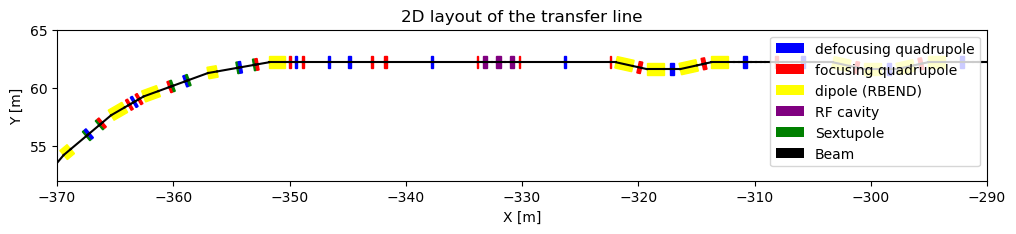

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
angle_tot=0 #cumulative total angle, needs to add up to 2pi after one turn
x_global,y_global=0,0 #global position in lab frame (not courant-snyder)
elem_width = 1 #width of an element for plotting in 2D
beam_width = 0.1
for type_,s_,L_,K1L_,angle_1 in zip(type,s,L,K1L,angle): #for each element, plot a rectangular patch in lab frame
    angle_=-1*angle_1 #MADX turns clockwise as positive in its coordinate system
    x=x_global #update local coordinate
    y=y_global
    if 'QUADRUPOLE' in type_:
        if K1L_<0: #if defocusing
            ax.add_patch(Rectangle((x, y), L_, elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='blue'))
            ax.add_patch(Rectangle((x, y), L_, -elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='blue'))
        else: #if focusing
            ax.add_patch(Rectangle((x, y), L_, elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='red'))
            ax.add_patch(Rectangle((x, y), L_, -elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='red'))
        #plt.text(x,y+0.6*elem_width,s=r"$K_1$="+str(round(K1L_/L_,3)))
    elif 'RFCAVITY' in type_:
        ax.add_patch(Rectangle((x, y), L_, elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='purple'))
        ax.add_patch(Rectangle((x, y), L_, -elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='purple'))
    elif 'RBEND' in type_:
       ax.add_patch(Rectangle((x, y), L_, elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='yellow')) #left dipole patch
       ax.add_patch(Rectangle((x, y), L_, -elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='yellow')) #right dipole patch
       #plt.text(x,y-0.8*elem_width,s=r"$\theta$="+str(round(angle_*180/np.pi,2))+r"$^o$")
    elif 'SEXTUPOLE' in type_:
        ax.add_patch(Rectangle((x, y), L_, elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='green'))
        ax.add_patch(Rectangle((x, y), L_, -elem_width/2,angle=180*(1+(angle_tot+angle_)/np.pi),color='green'))

    x_global-=L_*np.cos((angle_tot+angle_))#update global (starting) position for the next element
    y_global-=L_*np.sin((angle_tot+angle_))
    plt.plot([x,x_global],[y,y_global],color='black') #draw a line for the beam
    angle_tot += angle_ #update cumulative angle (in radians)

plt.xlim(-370,-290)
plt.ylim(52,65)

#plt.xlim(-390,-290)
#plt.ylim(-5,65)

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
ax = plt.gca() #handle needed to fix aspect ratio of the plot (to preserve angles!)
ax.set_aspect(1) #fix aspect ratio

hndl = [Patch(facecolor='blue', label='defocusing quadrupole'),#make a legend corresponding to the color patches signifying lattice elements
        Patch(facecolor='red', label='focusing quadrupole'),
        Patch(facecolor='yellow', label='dipole (RBEND)'),
        Patch(facecolor='purple', label='RF cavity'),
        Patch(facecolor='green', label='Sextupole'),
        Patch(facecolor='black', label='Beam')]
ax.legend(handles=hndl,loc='upper right')
plt.title('2D layout of the transfer line')
plt.savefig('jupyter_plots/Transfer_lattice.jpg', bbox_inches='tight')

The following cell reads and plots the dispersion function:

(400.0, 559.7096444)

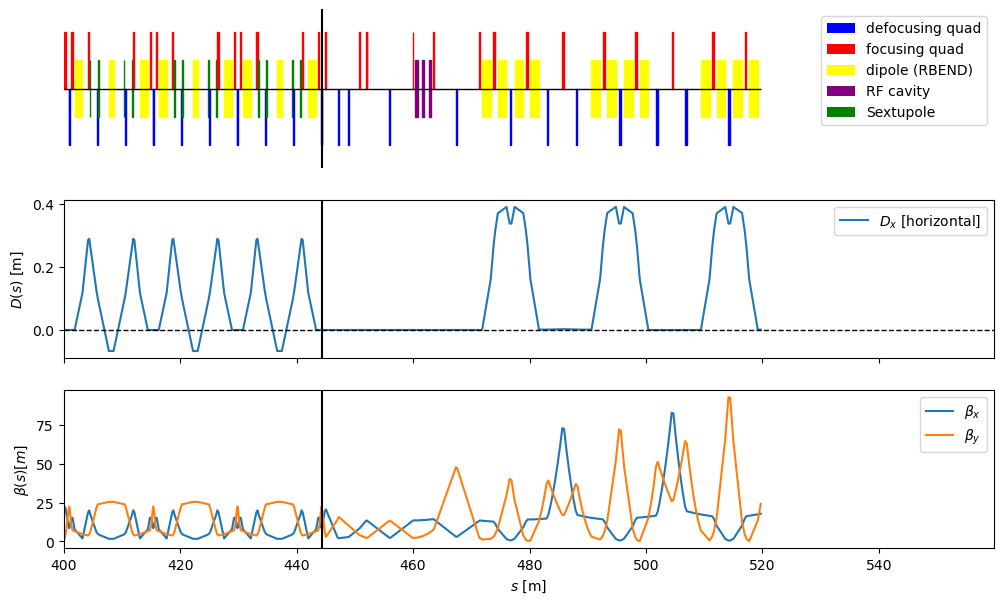

In [26]:
fig, ax = plt.subplots(3,1,figsize=(12,7),sharex=True)
elem_width=0.5
for type_,s_,L_,K1L_ in zip(type,s,L,K1L): #for each element, plot a rectangular patch in lab frame
    if 'QUADRUPOLE' in type_:
        if K1L_<0: #if defocusing
            ax[0].add_patch(Rectangle((s_-L_,0), L_, -elem_width,color='blue'))
        else: #if focusing
            ax[0].add_patch(Rectangle((s_-L_,0), L_, elem_width,color='red'))
    elif 'RFCAVITY' in type_:
        ax[0].add_patch(Rectangle((s_-L_,-elem_width/2), L_, elem_width,color='purple'))
    elif 'RBEND' in type_:
       ax[0].add_patch(Rectangle((s_-L_, -elem_width/2), L_, elem_width,color='yellow')) #left dipole patch
       #plt.text(x,y-0.8*elem_width,s=r"$\theta$="+str(round(angle_*180/np.pi,2))+r"$^o$")
    elif 'SEXTUPOLE' in type_:
        ax[0].add_patch(Rectangle((s_-L_,-elem_width/2), L_, elem_width,color='green'))


xmin=400
x_end = 444.4
ax[0].set_ylim(-0.7,0.7)
ax[0].axis('off')
ax[0].hlines(y=0, xmin=xmin, xmax=s[-1]+L[-1], color='black',linewidth=1)
#plt.axhline(y=0,color='black',linestyle='--',linewidth=1)
ax[0].axvline(x=x_end,color='black')

hndl = [Patch(facecolor='blue', label='defocusing quad'),#make a legend corresponding to the color patches signifying lattice elements
        Patch(facecolor='red', label='focusing quad'),
        Patch(facecolor='yellow', label='dipole (RBEND)'),
        Patch(facecolor='purple', label='RF cavity'),
        Patch(facecolor='green', label='Sextupole')]
ax[0].legend(handles=hndl,loc='upper right')

ax[1].plot(s,Dx,label=r'$D_x$ [horizontal]')
#ax[1].plot(s,dDx,'.--',label=r'$dD_x$ [horizontal]')
ax[1].legend(loc="upper right")
ax[1].set_ylabel(r'$D(s)$ [m]')
ax[1].axvline(x=x_end,color='black')
ax[1].axhline(y=0,color='black',linestyle='--',linewidth=1)

ax[2].plot(s,betx,label=r'$\beta_x$')
ax[2].plot(s,bety,label=r'$\beta_y$')
ax[2].axvline(x=x_end,color='black')
ax[2].set_ylabel(r'$\beta (s) [m]$')
ax[2].set_xlabel(r'$s$ [m]')

plt.legend()
plt.xlim(xmin,s[-1]+40)

In [27]:
filename = "madx_scripts/eL2L2_rebecca/tracking_data/track.outone"
copy_lines=[]
with open(filename) as f: #open and read the file
    lines = f.readlines()
for line in lines: 
    split_line = line.split() #split lines into words
    copy_lines.append(split_line)

segment_count=0
segments=[]
#from each line, extract a name/number and append it into its relevant column
for i in range(52,len(copy_lines)-1): #53rd line in the file is the first relevant one
    line = copy_lines[i]
    if ("segment" in line[0]):
        segment_data=[]
        seg_num = int(line[1])
        seg_name=str(line[5])
        n_parts = int(line[3])
        segment_count+=1

        segm_list = copy_lines[i+1:i+1+n_parts]
        x =  np.array([float(row[2]) for row in segm_list])
        px = np.array([float(row[3]) for row in segm_list])
        y =  np.array([float(row[4]) for row in segm_list])
        py = np.array([float(row[5]) for row in segm_list])
        T =  np.array([float(row[6]) for row in segm_list])
        PT = np.array([float(row[7]) for row in segm_list])

        segment_data.append(seg_num)
        segment_data.append(seg_name)
        segment_data.append(n_parts)
        segment_data.append(x)
        segment_data.append(px)
        segment_data.append(y)
        segment_data.append(py)
        segment_data.append(T)
        segment_data.append(PT)

        segments.append(segment_data)

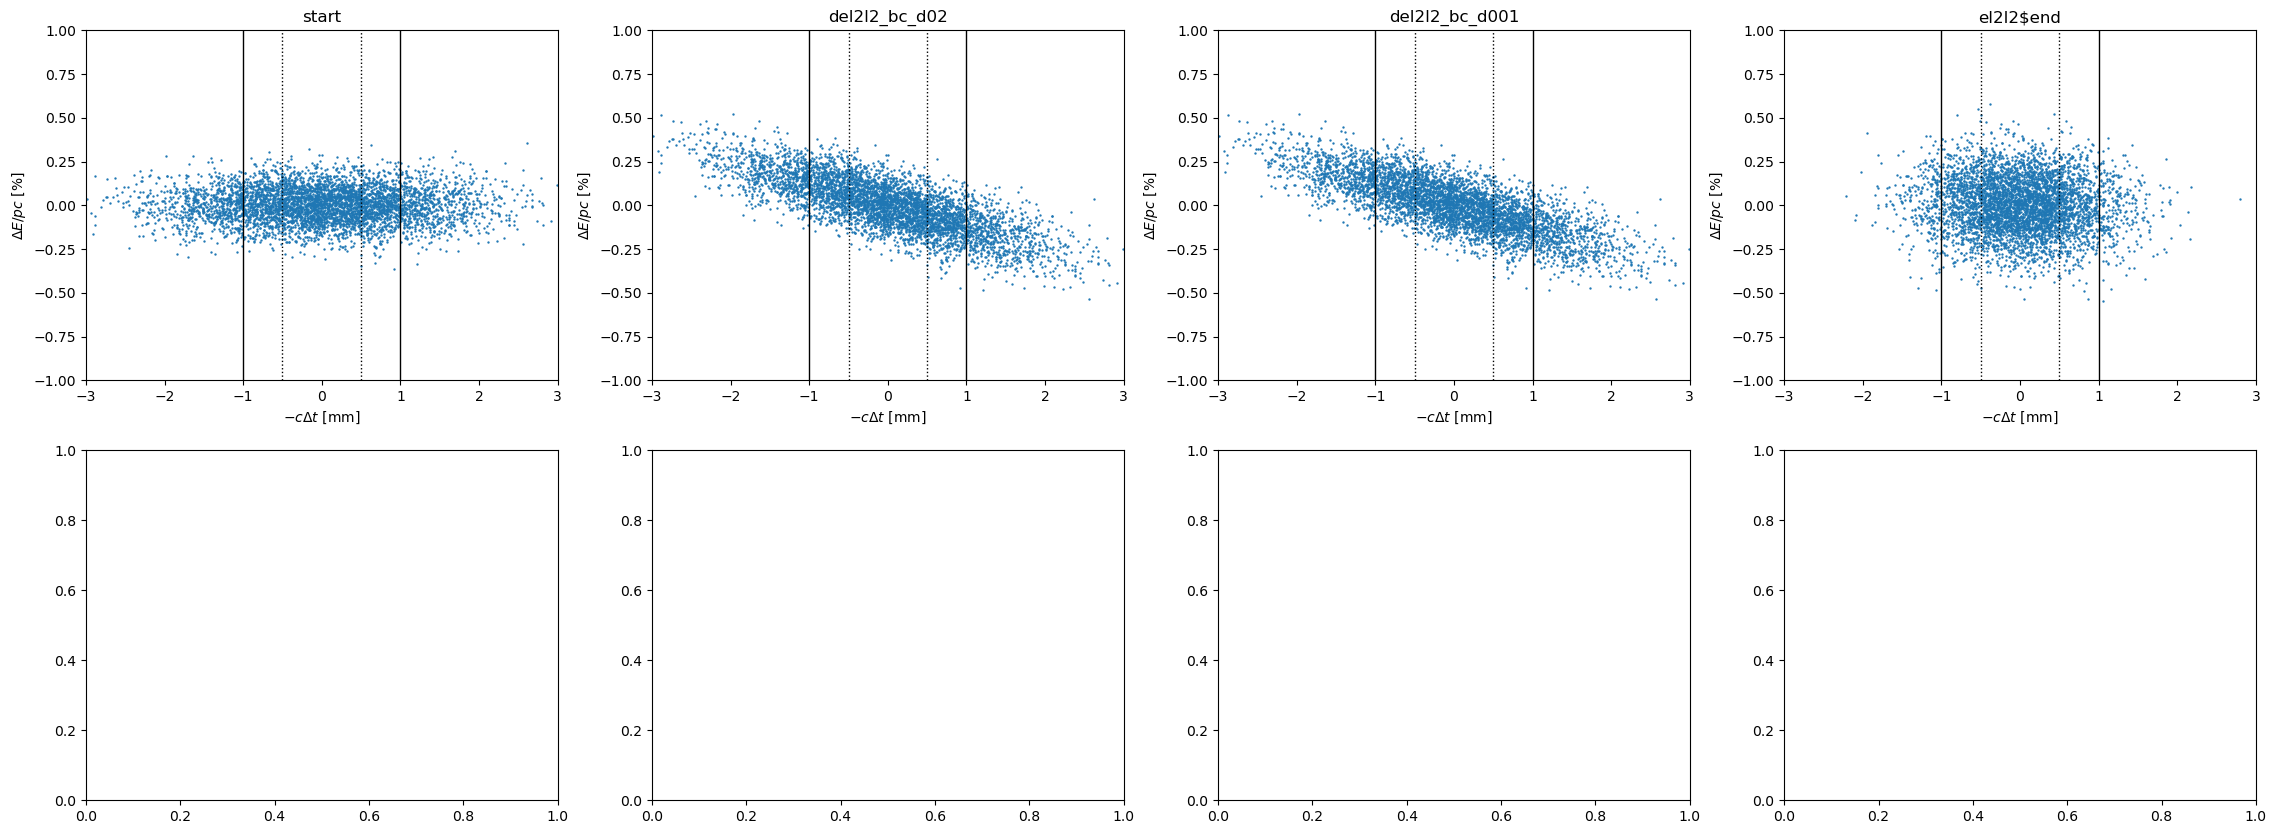

In [28]:
N=len(segments)
n_cols=4
n_rows=int((n_cols+N-(N%n_cols))/(n_cols))

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(7*n_cols,5*n_rows),dpi=100)
m_s=0.5 #markersize andle
x_color = 'tab:green'
y_color = 'tab:orange'
t_color = 'tab:blue'

num=0
for row in range(n_rows):
    for col in range(n_cols):
        if num<N:
            T=segments[num][7]
            PT=segments[num][8]
            name=segments[num][1]
            ax[row][col].scatter(T*1e3,PT*100,s=m_s,color=t_color)
            ax[row][col].axvline(x=-1,color='black',linewidth=1)
            ax[row][col].axvline(x=1,color='black',linewidth=1)
            ax[row][col].axvline(x=-0.5,color='black',linewidth=1,linestyle='dotted')
            ax[row][col].axvline(x=0.5,color='black',linewidth=1,linestyle='dotted')
            ax[row][col].set_xlim(-3,3)
            ax[row][col].set_ylim(-1,1)
            ax[row][col].set_xlabel(r"$-c\Delta t$ [mm]")
            ax[row][col].set_ylabel(r"$\Delta E/pc$ [%]")
            ax[row][col].set_title(name)
            num+=1

#plt.savefig('jupyter_plots/phase_space_tracking.jpg', bbox_inches='tight')



Text(0.5, 1.0, 'start')

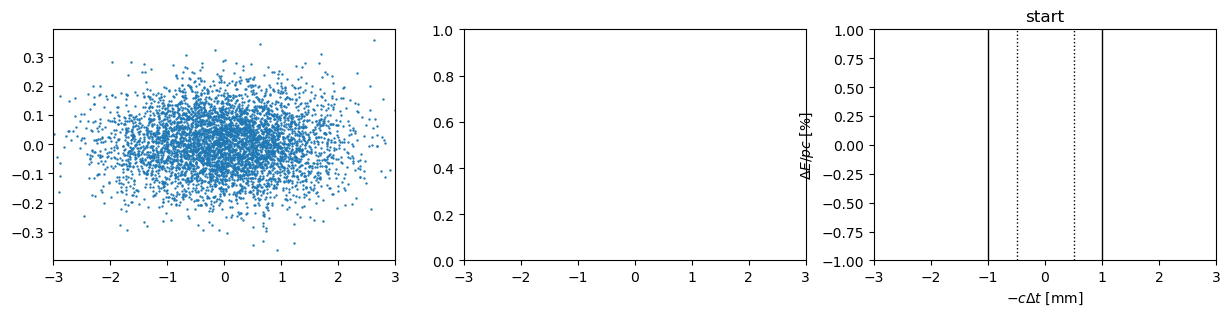

In [30]:
fig, ax = plt.subplots(1,3,figsize=(15,3),sharex=True)
for num in range(3):
    T=segments[num][7]
    PT=segments[num][8]
    name=segments[num][1]
    ax[num].scatter(T*1e3,PT*100,s=m_s,color=t_color)
    plt.axvline(x=-1,color='black',linewidth=1)
    plt.axvline(x=1,color='black',linewidth=1)
    plt.axvline(x=-0.5,color='black',linewidth=1,linestyle='dotted')
    plt.axvline(x=0.5,color='black',linewidth=1,linestyle='dotted')
    plt.xlim(-3,3)
    plt.ylim(-1,1)
    plt.xlabel(r"$-c\Delta t$ [mm]")
    plt.ylabel(r"$\Delta E/pc$ [%]")
plt.title(name)

In [ ]:
import sympy as smp #library for symbolic mathematics
from sympy import symbols, diff, integrate, oo,tan
from sympy import *

theta,K_1,K_2,theta_Q1,delta,delta_xQ2,L_1Q,L_BM,R_56,L_12,L_Q2,L_2h=symbols("theta K_1 K_2 theta_Q1 delta delta_xQ2 L_1Q L_BM R_56 L_12 L_Q2 L_2h",real=True)
theta_Q1_new = symbols("theta_new",real=True)

In [ ]:
theta_Q1=K_1/(1+delta)*(L_1Q*(smp.tan(theta/(1+delta))-smp.tan(theta))+L_BM*(smp.tan(theta/(2*(1+delta)))-smp.tan(theta/2)))
theta_Q1

In [ ]:
R_56 = -2*(L_12+2*L_BM/3)*theta**2-L_BM*theta**2-2*K_1*(L_1Q+L_BM/2)*(L_Q2+L_BM/2)*theta**2
R_56

In [ ]:
delta_xQ2=L_BM*smp.tan(theta/(2*(1+delta)))+L_1Q*smp.tan(theta/(1+delta))+L_Q2*smp.tan((theta+theta_Q1_new)/(1+delta))+L_BM*smp.tan((theta/2+theta_Q1_new)/(1+delta))+L_2h*smp.tan(theta_Q1_new/(1+delta))-L_12*smp.tan(theta)-2*L_BM*smp.tan(theta/2)
delta_xQ2

In [ ]:
L_BM_=1 #m
theta_=12.5*np.pi/180
L_1Q_ = 0.85 #First dipole end to first quadrupole distance [m]
L_Q2_ = 0.85 #First quadrupole magnet to second dipole start 
L_12_ = 2.0 #Total distance between first dipole end to start of second dipole
L_2h_ = 1.2  #Second dipole magnet end to second quadrupole magnet
delta_ = 0.0 #
K_1_list=np.linspace(-3,3,100)
K_1_pick=1.8

R_56_func=smp.lambdify([K_1,theta,L_1Q,L_BM,L_Q2,L_12],R_56)
R_56_=R_56_func(K_1_list,theta_,L_1Q_,L_BM_,L_Q2_,L_12_)

plt.plot(K_1_list,R_56_)
plt.xlabel(r"K1 [$m^{-1}$]")
plt.ylabel(r"$R_{56}$ [m]")

In [ ]:
theta_Q1_func=smp.lambdify([K_1,theta,L_1Q,L_BM,delta],theta_Q1)
theta_Q1_=theta_Q1_func(K_1_pick,theta_,L_1Q_,L_BM_,delta_)

delta_xQ2_func=smp.lambdify([L_12,theta,L_1Q,delta,L_2h,L_BM,theta_Q1_new,L_Q2],delta_xQ2)
delta_xQ2_=delta_xQ2_func(L_12_,theta_,L_1Q_,delta_,L_2h_,L_BM_,theta_Q1_,L_Q2_)

In [ ]:
R_56_pick=R_56_func(K_1_pick,theta_,L_1Q_,L_BM_,L_Q2_,L_12_)

theta_Q1_pick=theta_Q1_func(K_1_pick,theta_,L_1Q_,L_BM_,delta_)
delta_xQ2_pick=delta_xQ2_func(L_12_,theta_,L_1Q_,delta_,L_2h_,L_BM_,theta_Q1_pick,L_Q2_)
K_2 = 2*theta_Q1_pick/delta_xQ2_pick*(1+delta_)

print("K1 (picked): {:.3f}".format(K_1_pick))
print("R_56: {:.3f}".format(R_56_pick))
print("K2 (necessary): {:.3f}".format(K_2))